#Proyek Klasifikasi Gambar: deteksi pemakaian masker


### Import Library

In [1]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
!pip install tensorflow
!pip install tensorflowjs
import tensorflow as tf
from tensorflow.keras import Model, models , layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import Input, InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

from PIL import Image

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#import library untuk kaggle
!pip install kaggle

#install tensorflowjs
!pip install tensorflowjs


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [2]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"thirafiqaedi","key":"c6692059da83c1cdc3f45a625920bc30"}'}

### download data dari kaggle

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset
!unzip face-mask-12k-images-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Face Mask Dataset/Train/WithoutMask/1855.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1856.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1857.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1858.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1859.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1860.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1861.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1862.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1863.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1864.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1865.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1866.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1867.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1868.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1869.png  
  inflating: Face Mask Dataset/Train/WithoutMask/

### import data dan data spliting

In [5]:
train_path_dir = "/content/Face Mask Dataset/Train"
test_path_dir = "/content/Face Mask Dataset/Test"
validation_path_dir = "/content/Face Mask Dataset/Validation"


# function untuk check jumlah gambar per directori
def print_images_Total(dir):
    unique_sizes = set()
    total_images = 0
    for subdir in os.listdir(dir):
        subdir_path = os.path.join(dir, subdir)
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images

    print(f"\nTotal: {total_images}")



In [6]:
print_images_Total(train_path_dir)

WithMask: 5000
WithoutMask: 5000

Total: 10000


In [7]:
print_images_Total(test_path_dir)

WithMask: 483
WithoutMask: 509

Total: 992


In [8]:
print_images_Total(validation_path_dir)

WithMask: 400
WithoutMask: 400

Total: 800


###Data Preprocessing

In [9]:
generated_train_data = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
generated_val_test_data = ImageDataGenerator(rescale=1.0/255.0)

img_height, img_width = 224, 224
batch_size = 32

validat_data = generated_val_test_data.flow_from_directory(
    validation_path_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)
test_data = generated_val_test_data.flow_from_directory(
    test_path_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
train_data = generated_train_data.flow_from_directory(
    train_path_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.


### Modeling

In [10]:
num_classes = len(train_data.class_indices)

model_classfy = models.Sequential()
model_classfy.add(Input(shape=(img_height, img_width, 3)))

# Layer 1
model_classfy.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_classfy.add(layers.BatchNormalization())
model_classfy.add(layers.MaxPooling2D((2, 2)))

# Layer 2
model_classfy.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_classfy.add(layers.BatchNormalization())
model_classfy.add(layers.MaxPooling2D((2, 2)))

# Layer 3
model_classfy.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_classfy.add(layers.BatchNormalization())
model_classfy.add(layers.MaxPooling2D((2, 2)))

model_classfy.add(layers.Flatten())
model_classfy.add(layers.Dense(256, activation='relu'))
model_classfy.add(layers.Dropout(0.5))
model_classfy.add(layers.Dense(num_classes, activation='softmax'))

# Compile model
model_classfy.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

model_classfy.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,246,082 (84.86 MB)

 Trainable params: 22,245,634 (84.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [11]:
# Implementasi point Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_LROnPlateau = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Training Model
history = model_classfy.fit(
    train_data,
    validation_data=validat_data,
    epochs= 30,
    callbacks=[early_stopping, reduce_LROnPlateau]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 425ms/step - accuracy: 0.8666 - loss: 5.0353 - val_accuracy: 0.6725 - val_loss: 15.5525 - learning_rate: 0.0010
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 126s 403ms/step - accuracy: 0.9184 - loss: 0.3490 - val_accuracy: 0.9787 - val_loss: 0.0715 - learning_rate: 0.0010
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 128s 408ms/step - accuracy: 0.9351 - loss: 0.2167 - val_accuracy: 0.9725 - val_loss: 0.0740 - learning_rate: 0.0010
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 126s 404ms/step - accuracy: 0.9427 - loss: 0.1876 - val_accuracy: 0.9613 - val_loss: 0.0975 - learning_rate: 0.0010
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 126s 401ms/step - accuracy: 0.9333 - loss: 0.2145 - val_accuracy: 0.8075 - val_loss: 0.9313 - learning_rate: 0.0010
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 126s 401ms/step - accuracy: 0.9529 - loss: 0.1670 - val_accuracy: 0.9862 - val_loss: 0.0429 - learning_rate: 2.0000e-04
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 398ms/step - a

### Evaluasi Model

In [12]:
# Evaluasi pada validation set
loss_val, acc_val = model_classfy.evaluate(validat_data)
print(f"Accuracy of Validation : {acc_val:.2%}")
print(f"Validation Loss: {loss_val:.4f}")

# Evaluasi pada testing set
loss_test, acc_test = model_classfy.evaluate(test_data)
print(f"Accuracy of Testing : {acc_test:.2%}")
print(f"Testing Loss: {loss_test:.4f}")


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9959 - loss: 0.0177
Accuracy of Validation : 99.50%
Validation Loss: 0.0166
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9943 - loss: 0.0148
Accuracy of Testing : 99.50%
Testing Loss: 0.0154


### # Visualisasi plot Akurasi dan Loss

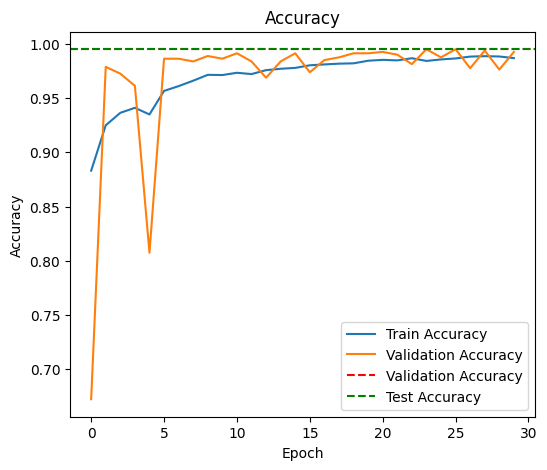

In [13]:
# Plot Akurasi
plt.figure(figsize=(6, 5))

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=acc_val, color='r', linestyle='--', label='Validation Accuracy')
plt.axhline(y=acc_test, color='g', linestyle='--', label='Test Accuracy')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

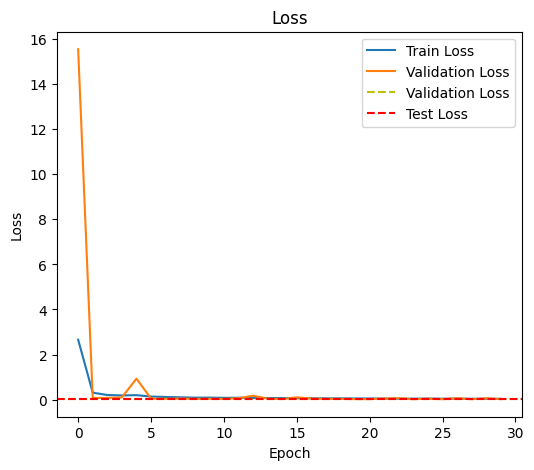

In [14]:
# Plot Loss
plt.figure(figsize=(6, 5))

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=loss_val, color='y', linestyle='--', label='Validation Loss')
plt.axhline(y=loss_test, color='r', linestyle='--', label='Test Loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

###Menyimpan Model

In [15]:
# SavedModel
save_path = 'SavedModel'
tf.saved_model.save(model_classfy, save_path)

In [16]:
# TF-Lite
convert_model_TLite = tf.lite.TFLiteConverter.from_keras_model(model_classfy)
tflite_model = convert_model_TLite.convert()

tflite_model_dir = 'tf_lite_model'
if not os.path.exists(tflite_model_dir):
    os.makedirs(tflite_model_dir)

tflite_model_path = os.path.join(tflite_model_dir, 'model.tflite')
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

# Simpan label untuk model TF-Lite
class_labels = list(train_data.class_indices.keys())
with open("tf_lite_model/label.txt", "w") as f:
    for label in class_labels:
        f.write(label + "\n")

Saved artifact at '/tmp/tmp7ajjy_tq'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  132553898655568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132553898655376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132553870819408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132553870822288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132553870821520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132553870823056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132553870824400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132553870825168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132553870824592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132553870826896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13255387082651

In [17]:
# TFJS
model_classfy.save('model_name.h5')
!tensorflowjs_converter --input_format=keras model_name.h5 tfjs_model

2025-05-08 09:43:03.426365: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746697383.446352   18666 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746697383.453332   18666 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


###(opsional) Inference (Menggunakan TF-Lite)

In [18]:
# Label kelas
class_labels = ["With Mask", "Without Mask"]
model_tflite_path='/content/tf_lite_model/model.tflite'

#membuat Function untuk predict
def _tflite_predict(image_path, model_path):
    # Load model
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    # Ambil detail input & output
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Ambil ukuran input model
    img_height, img_width = input_details[0]['shape'][1:3]

    # Load dan preprocess gambar
    img = Image.open(image_path).resize((img_height, img_width))
    img_array = np.array(img, dtype=np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan dimensi batch

    # Set input model
    interpreter.set_tensor(input_details[0]['index'], img_array)
    interpreter.invoke()

    # Ambil hasil prediksi
    predictions = interpreter.get_tensor(output_details[0]['index'])[0]

    # Dapatkan kelas dengan probabilitas tertinggi
    predicted_class = np.argmax(predictions)
    confidence = predictions[predicted_class] * 100

    # Tampilkan hasil prediksi
    print(f"\n=== HASIL PREDIKSI ===")
    for i, prob in enumerate(predictions):
        print(f"{class_labels[i]}: {prob:.4f}")

    print(f"\nKelas Terpilih: {class_labels[predicted_class]} ({confidence:.2f}%)")

    return class_labels[predicted_class], confidence



##### case 1 with mask

In [19]:
# Path gambar yang akan diuji
image_path_case1 = "/content/Face Mask Dataset/Test/WithMask/1612.png"

# Jalankan prediksi
predicted_label, confidence = _tflite_predict(image_path_case1,model_tflite_path)


=== HASIL PREDIKSI ===
With Mask: 1.0000
Without Mask: 0.0000

Kelas Terpilih: With Mask (100.00%)


##### case 2 without mask

In [20]:
# Path gambar yang akan diuji
image_path_case2 = "/content/Face Mask Dataset/Test/WithoutMask/1216.png"

# Jalankan prediksi
predicted_label, confidence = _tflite_predict(image_path_case2,model_tflite_path)


=== HASIL PREDIKSI ===
With Mask: 0.0003
Without Mask: 0.9997

Kelas Terpilih: Without Mask (99.97%)


###DOnwload ZIP model dan requirement

In [22]:
shutil.make_archive('/content/SavedModel', 'zip', '/content/SavedModel')

'/content/SavedModel.zip'

In [23]:
shutil.make_archive('/content/tf_lite_model', 'zip', '/content/tf_lite_model')

'/content/tf_lite_model.zip'

In [24]:
shutil.make_archive('/content/tfjs_model', 'zip', '/content/tfjs_model')

'/content/tfjs_model.zip'

In [25]:
!pip freeze requirements.txt

absl-py==1.4.0
accelerate==1.6.0
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.6
ale-py==0.11.0
altair==5.5.0
annotated-types==0.7.0
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.2
arviz==0.21.0
astropy==7.0.1
astropy-iers-data==0.2025.4.28.0.37.27
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
backports.tarfile==1.2.0
beautifulsoup4==4.13.4
betterproto==2.0.0b6
bigframes==2.1.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blosc2==3.3.2
bokeh==3.7.2
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
build==1.2.2.post1
CacheControl==0.14.3
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.4.26
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.1
chex==0.1.89
clarabel==0.10.0
click==8.1.8
cloudpathlib==0.21.0
cloudpickle==3.1.1
cmake==3.31.6
cmdstanpy==1.2.5
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
commun